<a href="https://colab.research.google.com/github/MKolaksazov/Data-Science/blob/main/Colab%20code%20(graphs)/Gouped_bars_grasses_1002.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
# PARAMETERS
csv_file = '/content/gr_bca_240813_all.csv' #"/content/lupin_PM_0602_ew.csv" #/content/lupina-params-1.csv


In [32]:
import pandas as pd
import numpy as np

df = pd.read_csv(csv_file, delimiter='\t', decimal=',') # delimiter '\t' or ';'

# Convert 'rep1' and 'rep2' columns to numeric, handling errors
df['rep1'] = pd.to_numeric(df['rep1'], errors='coerce')
df['rep2'] = pd.to_numeric(df['rep2'], errors='coerce')

# Check for missing values in 'rep1' and 'rep2'
print(df.isnull().sum())

species    0
month      0
method     0
rep1       0
rep2       0
dtype: int64


In [33]:
df_long = pd.melt(df, id_vars=['species', 'month', 'method'], value_vars=['rep1', 'rep2'], var_name='replicate', value_name='value')

In [34]:
value = 'value'
variant = 'species'
condition = (df_long['method'] == 'PM') & (df_long['month'] == 'morning')

import statsmodels.stats.multicomp as mc

def multi_comparison(dataVariant):
  list_unique = dataVariant[variant].unique().tolist()

  model = mc.MultiComparison(dataVariant[value].astype('float'), dataVariant[variant])
  result = model.tukeyhsd()
  return result, list_unique

In [35]:
print(df_long.dtypes)

species       object
month         object
method        object
replicate     object
value        float64
dtype: object


In [36]:
result, list_unique = multi_comparison(df_long[condition])

In [37]:
def letter_ordering(df_ltr, thsd, list_u):
  new_df_ltr = np.array(df_ltr.sum(axis=1))
  new_ltr = []

  # ORDERING OF THE LETTERS!!!
  for i in range(len(list_u)):
    ltr = [list_u[i], thsd.groupsunique.tolist().index(list_u[i]),
    new_df_ltr[thsd.groupsunique.tolist().index(list_u[i])]]
    new_ltr.append(ltr[2])
    print(ltr)
  #print(np.array(df_ltr.sum(axis=1)), new_ltr)
  return new_ltr

In [38]:
import scipy.stats as stats

def letters_calculate(col_to_group, col_for_data, data, list_u):
  #Now take teh data and regroup for anova
  samples = [cols[1] for cols in data.groupby(col_to_group)[col_for_data]]
  #samples = np.asarray(samples).astype('float')
  #print (np.asarray(samples).astype('float'))
  #I am not sure how this works but it makes an numpy array for each group
  print(samples)
  f_val, p_val = stats.f_oneway(*samples)
  # I am not sure what this star does but this passes all the numpy arrays correctly

  # this if statement can be uncommmented if you don't won't to go furhter with out p<0.05
  #if p_val<0.05:    #If the p value is less than 0.05 it then does the tukey
  mod = mc.MultiComparison(data[col_for_data].astype('float'), data[col_to_group])
  thsd=mod.tukeyhsd()

  #this is a function to do Piepho method.
  #AN Alogrithm for a letter based representation of al-pairwise comparisons.
  tot=len(thsd.groupsunique)
  #make an empty dataframe that is a square matrix of size of the groups. #set first column to 1
  df_ltr=pd.DataFrame(np.nan, index=np.arange(tot),columns=np.arange(tot))
  #df_ltr.iloc[:,0]=1
  df_ltr[df_ltr.columns[0]] = 1
  #df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)

  count=0
  df_nms = pd.DataFrame('', index=np.arange(tot), columns=['names'])
  # I make a dummy dataframe to put axis labels into.  sd stands for signifcant difference
  for i in np.arange(tot):   #I loop through and make all pairwise comparisons.
      for j in np.arange(i+1,tot):
          #print('i=',i,'j=',j,thsd.reject[count])
          if thsd.reject[count]==True:
              for cn in np.arange(tot):
                  if df_ltr.iloc[i,cn]==1 and df_ltr.iloc[j,cn]==1:
                    #If the column contains both i and j shift and duplicat
                      df_ltr=pd.concat([df_ltr.iloc[:,:cn+1],df_ltr.iloc[:,cn+1:].T.shift().T],axis=1)
                      df_ltr[df_ltr.columns[cn+1]]=df_ltr[df_ltr.columns[cn]]
                      df_ltr.iloc[i,cn]=0
                      df_ltr.iloc[j,cn+1]=0
                  #Now we need to check all columns for abosortpion.
                  for cleft in np.arange(len(df_ltr.columns)-1):
                      for cright in np.arange(cleft+1,len(df_ltr.columns)):
                          if (df_ltr[df_ltr.columns[cleft]].isna()).all()==False and (df_ltr[df_ltr.columns[cright]].isna()).all()==False:
                              if (df_ltr[df_ltr.columns[cleft]]>=df_ltr[df_ltr.columns[cright]]).all()==True:
                                  df_ltr[df_ltr.columns[cright]]=0
                                  df_ltr=pd.concat([df_ltr[df_ltr.columns[:cright]],df_ltr[df_ltr.columns[cright:]].T.shift(-1).T],axis=1)
                              if (df_ltr[df_ltr.columns[cleft]]<=df_ltr[df_ltr.columns[cright]]).all()==True:
                                  df_ltr[df_ltr.columns[cleft]]=0
                                  df_ltr=pd.concat([df_ltr[df_ltr.columns[:cleft]],df_ltr[df_ltr.columns[cleft:]].T.shift(-1).T],axis=1)

          count+=1

  #I sort so that the first column becomes A
  df_ltr=df_ltr.sort_values(by=list(df_ltr.columns),axis=1,ascending=False)

  # I assign letters to each column
  for cn in np.arange(len(df_ltr.columns)):
      df_ltr[df_ltr.columns[cn]]=df_ltr[df_ltr.columns[cn]].replace(1,chr(97+cn))
      df_ltr[df_ltr.columns[cn]]=df_ltr[df_ltr.columns[cn]].replace(0,'')
      df_ltr[df_ltr.columns[cn]]=df_ltr[df_ltr.columns[cn]].replace(np.nan,'')
      #print(df_ltr.columns[cn])

  #I put all the letters into one string
  df_ltr=df_ltr.astype(str)
  df_ltr.sum(axis=1)

  letter_order = letter_ordering(df_ltr, thsd, list_u)
  #print (letter_order, list_u)
  return letter_order, df_ltr

In [39]:
months = pd.unique(df['month'].values).tolist()
methods = pd.unique(df['method'].values).tolist()
combinations = np.array(np.meshgrid(months, methods)).T.reshape(-1, 2)

In [40]:
stat_result = df_long.groupby(['species','method','month'], as_index=False, sort=False).agg({value:['mean','std']})
menMeans = stat_result['value']['mean']
menStd = stat_result['value']['std']

```
new_ltr = {}

combined_col = df_long.copy()
combined_col['combined'] = df_long['month'] + df_long['method']
list_unique = combined_col['combined'].unique().tolist()

for species in df_long['species'].unique():
  condition = (combined_col['species'] == species)
  new_ltr[species], _ = letters_calculate('combined', value, combined_col[condition], list_unique)
#print (new_ltr)
```

In [41]:
# Създаване на combined колона
df_long['combined'] = df_long['month'] + df_long['method']

# Получаване на списък с уникални стойности в combined колоната
unique_combined_values = df_long['combined'].unique().tolist()

# Функция за изчисляване на букви за всяка група
def calculate_letters_for_group(group):
  return letters_calculate('combined', value, group, unique_combined_values)

# Изчисляване на букви за всяка species група
# Този подход използва groupby за групиране по species
# и след това прилага функцията calculate_letters към всяка група.
# Резултатите се запазват в речник letters_by_species.

letters_by_species = df_long.groupby('species').apply(calculate_letters_for_group).to_dict()

[15    2.416248
57    2.411843
Name: value, dtype: float64, 29    1.977688
71    2.112914
Name: value, dtype: float64, 1     2.988716
43    2.966974
Name: value, dtype: float64, 22    2.676155
64    2.671750
Name: value, dtype: float64, 36    1.817106
78    2.991886
Name: value, dtype: float64, 8     3.630095
50    3.765980
Name: value, dtype: float64]
['morningPM', 2, 'ab']
['noonPM', 5, 'b']
['morningFRAP', 0, 'ab']
['noonFRAP', 3, 'ab']
['morningFolin', 1, 'a']
['noonFolin', 4, 'ab']
[16    2.319334
58    2.425059
Name: value, dtype: float64, 30    1.580460
72    2.079108
Name: value, dtype: float64, 2     2.852831
44    2.765864
Name: value, dtype: float64, 23    3.766440
65    3.678336
Name: value, dtype: float64, 37    2.662272
79    2.696078
Name: value, dtype: float64, 9     4.249732
51    4.353005
Name: value, dtype: float64]
['morningPM', 2, 'b']
['noonPM', 5, 'c']
['morningFRAP', 0, 'ab']
['noonFRAP', 3, 'c']
['morningFolin', 1, 'a']
['noonFolin', 4, 'b']
[20     6.858886
62

<ipython-input-41-27185488bfc0>:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  letters_by_species = df_long.groupby('species').apply(calculate_letters_for_group).to_dict()


In [42]:
result_values = {}
result_errors = {}
new_ltr = {}
month_labels = months
method_labels = methods
i = 1


for method in method_labels:
  for month in month_labels:

    result_values[f'y{i}'] = stat_result[stat_result['method'] == method]\
     [stat_result['month'] == month]['value']['mean'].values

    result_errors[f'y{i}err'] = stat_result[stat_result['method'] == method]\
     [stat_result['month'] == month]['value']['std'].values

    condition = (df_long['method'] == method) & (df_long['month'] == month)
    list_unique = df_long[condition][variant].unique().tolist()

    print (df_long[condition].dtypes, list_unique)
    new_ltr[f'y{i}'], _ = letters_calculate(variant, value, df_long[condition], list_unique)

    i += 1
#print (result_values)

species       object
month         object
method        object
replicate     object
value        float64
combined      object
dtype: object ['L. perenne', 'A. cristatum', 'A. desertorum', 'F. arundinacea', 'F. pratensis', 'F. rubra', 'B. inermis']
[1     2.988716
43    2.966974
Name: value, dtype: float64, 2     2.852831
44    2.765864
Name: value, dtype: float64, 6     5.537925
48    7.587075
Name: value, dtype: float64, 3     3.543128
45    3.390937
Name: value, dtype: float64, 4     3.515951
46    3.407243
Name: value, dtype: float64, 5     5.233542
47    4.516067
Name: value, dtype: float64, 0     4.064928
42    4.200813
Name: value, dtype: float64]


<ipython-input-42-b9bb29eeeee5>:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result_values[f'y{i}'] = stat_result[stat_result['method'] == method]\
<ipython-input-42-b9bb29eeeee5>:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result_errors[f'y{i}err'] = stat_result[stat_result['method'] == method]\


['L. perenne', 6, 'a']
['A. cristatum', 0, 'a']
['A. desertorum', 1, 'a']
['F. arundinacea', 3, 'a']
['F. pratensis', 4, 'a']
['F. rubra', 5, 'ab']
['B. inermis', 2, 'b']
species       object
month         object
method        object
replicate     object
value        float64
combined      object
dtype: object ['L. perenne', 'A. cristatum', 'A. desertorum', 'F. arundinacea', 'F. pratensis', 'F. rubra', 'B. inermis']
[8     3.630095
50    3.765980
Name: value, dtype: float64, 9     4.249732
51    4.353005
Name: value, dtype: float64, 13    5.967322
55    5.766212
Name: value, dtype: float64, 10    3.967090
52    4.298651
Name: value, dtype: float64, 11    4.081234
53    3.923607
Name: value, dtype: float64, 12    4.597598
54    3.755109
Name: value, dtype: float64, 7     3.793157
49    4.227990
Name: value, dtype: float64]


<ipython-input-42-b9bb29eeeee5>:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result_values[f'y{i}'] = stat_result[stat_result['method'] == method]\
<ipython-input-42-b9bb29eeeee5>:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result_errors[f'y{i}err'] = stat_result[stat_result['method'] == method]\


['L. perenne', 6, 'a']
['A. cristatum', 0, 'a']
['A. desertorum', 1, 'a']
['F. arundinacea', 3, 'a']
['F. pratensis', 4, 'a']
['F. rubra', 5, 'a']
['B. inermis', 2, 'b']
species       object
month         object
method        object
replicate     object
value        float64
combined      object
dtype: object ['L. perenne', 'A. cristatum', 'A. desertorum', 'F. arundinacea', 'F. pratensis', 'F. rubra', 'B. inermis']
[15    2.416248
57    2.411843
Name: value, dtype: float64, 16    2.319334
58    2.425059
Name: value, dtype: float64, 20     6.858886
62    11.186988
Name: value, dtype: float64, 17    2.704789
59    2.709194
Name: value, dtype: float64, 18    2.436072
60    2.469111
Name: value, dtype: float64, 19    4.127666
61    4.376559
Name: value, dtype: float64, 14    1.951501
56    1.973527
Name: value, dtype: float64]


<ipython-input-42-b9bb29eeeee5>:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result_values[f'y{i}'] = stat_result[stat_result['method'] == method]\
<ipython-input-42-b9bb29eeeee5>:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result_errors[f'y{i}err'] = stat_result[stat_result['method'] == method]\


['L. perenne', 6, 'a']
['A. cristatum', 0, 'a']
['A. desertorum', 1, 'a']
['F. arundinacea', 3, 'a']
['F. pratensis', 4, 'a']
['F. rubra', 5, 'a']
['B. inermis', 2, 'b']
species       object
month         object
method        object
replicate     object
value        float64
combined      object
dtype: object ['L. perenne', 'A. cristatum', 'A. desertorum', 'F. arundinacea', 'F. pratensis', 'F. rubra', 'B. inermis']
[22    2.676155
64    2.671750
Name: value, dtype: float64, 23    3.766440
65    3.678336
Name: value, dtype: float64, 27    7.638605
69    7.764153
Name: value, dtype: float64, 24    2.843552
66    2.867781
Name: value, dtype: float64, 25    2.160747
67    2.173963
Name: value, dtype: float64, 26    3.455874
68    2.834742
Name: value, dtype: float64, 21    1.625516
63    1.614503
Name: value, dtype: float64]


<ipython-input-42-b9bb29eeeee5>:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result_values[f'y{i}'] = stat_result[stat_result['method'] == method]\
<ipython-input-42-b9bb29eeeee5>:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result_errors[f'y{i}err'] = stat_result[stat_result['method'] == method]\


['L. perenne', 6, 'e']
['A. cristatum', 0, 'ab']
['A. desertorum', 1, 'c']
['F. arundinacea', 3, 'a']
['F. pratensis', 4, 'be']
['F. rubra', 5, 'ac']
['B. inermis', 2, 'd']
species       object
month         object
method        object
replicate     object
value        float64
combined      object
dtype: object ['L. perenne', 'A. cristatum', 'A. desertorum', 'F. arundinacea', 'F. pratensis', 'F. rubra', 'B. inermis']
[29    1.977688
71    2.112914
Name: value, dtype: float64, 30    1.580460
72    2.079108
Name: value, dtype: float64, 34    5.265382
76    9.558824
Name: value, dtype: float64, 31    1.884719
73    1.926978
Name: value, dtype: float64, 32    1.597363
74    1.741041
Name: value, dtype: float64, 33    3.101758
75    3.279243
Name: value, dtype: float64, 28    2.129817
70    1.673428
Name: value, dtype: float64]


<ipython-input-42-b9bb29eeeee5>:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result_values[f'y{i}'] = stat_result[stat_result['method'] == method]\
<ipython-input-42-b9bb29eeeee5>:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result_errors[f'y{i}err'] = stat_result[stat_result['method'] == method]\


['L. perenne', 6, 'a']
['A. cristatum', 0, 'a']
['A. desertorum', 1, 'a']
['F. arundinacea', 3, 'a']
['F. pratensis', 4, 'a']
['F. rubra', 5, 'ab']
['B. inermis', 2, 'b']
species       object
month         object
method        object
replicate     object
value        float64
combined      object
dtype: object ['L. perenne', 'A. cristatum', 'A. desertorum', 'F. arundinacea', 'F. pratensis', 'F. rubra', 'B. inermis']
[36    1.817106
78    2.991886
Name: value, dtype: float64, 37    2.662272
79    2.696078
Name: value, dtype: float64, 41    6.338742
83    5.814740
Name: value, dtype: float64, 38    1.969236
80    2.112914
Name: value, dtype: float64, 39    1.614266
81    1.639621
Name: value, dtype: float64, 40    2.400270
82    2.019946
Name: value, dtype: float64, 35    1.386072
77    1.707235
Name: value, dtype: float64]


<ipython-input-42-b9bb29eeeee5>:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result_values[f'y{i}'] = stat_result[stat_result['method'] == method]\
<ipython-input-42-b9bb29eeeee5>:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result_errors[f'y{i}err'] = stat_result[stat_result['method'] == method]\


['L. perenne', 6, 'a']
['A. cristatum', 0, 'a']
['A. desertorum', 1, 'a']
['F. arundinacea', 3, 'a']
['F. pratensis', 4, 'a']
['F. rubra', 5, 'a']
['B. inermis', 2, 'b']


```
# water extracts
y1w = [1.02809021335807, 0.730954313543599, 0.930252782931354, 0.701965445269017, 0.701965445269017, 0.923005565862709, 1.13679846938776]
y2w = [0.875898654916512, 0.923005565862709, 1.19839981447124, 0.792555658627087, 0.767190398886828, 0.53890306122449, 0.803426484230056]

csv_file = '/content/gr_BCA_all_240826_w.csv' #"/content/lupin_PM_0602_ew.csv" #/content/lupina-params-1.csv
dfw = pd.read_csv(csv_file, delimiter='\t', decimal=',') # delimiter '\t' or ';'

y1w = dfw['y1w'].values
y2w = dfw['y2w'].values
y1werr = dfw['y1werr'].values
y2werr = dfw['y2werr'].values
```

In [50]:
def draw_letters(y, xx, data, new_l, follow_bars=False, bplt=0, fsize=10):

  for i, grp in enumerate(pd.unique(data)):   #I loop through the groups to make the scatters and figure out the axis labels.
      if follow_bars:
        y_pos = data[i] + .7 #+ y * 0.25
      else:
        y_pos = y * 0.98 #y_pos = ax.get_ylim()[1]*1

      #print (i, xx, y_pos, new_l[i], pd.unique(data))
      plt.text(i*0.1+xx+bplt, y_pos, new_l[i],
              rotation=90, fontsize=fsize, verticalalignment='top', horizontalalignment='center')

['b', 'b', 'a', 'a', 'a', 'a'] [4.22895590899849, 4.318047069741362, 1.9780882778951485, 1.6277971520997145, 2.224338794659179, 1.7737496423689108]
['ab', 'b', 'ab', 'ab', 'a', 'ab'] [2.9932189264230633, 3.794122884879748, 2.417160812375718, 2.677067210830726, 2.1409204572260383, 3.235191367350662]
['b', 'c', 'ab', 'c', 'a', 'b'] [2.870842136582777, 4.374393202341635, 2.4469551425717695, 3.7846870886594988, 2.1823808324037, 2.703080012886633]
['c', 'd', 'a', 'a', 'b', 'b'] [3.5746480925681063, 4.367318930015689, 2.710106159786865, 2.872798668999622, 1.9357296645193838, 2.142670852604559]
['c', 'e', 'a', 'd', 'b', 'b'] [3.538465341762802, 4.113879670764792, 2.475953375694695, 2.176699877463208, 1.770797965518689, 1.64487255192325]
['b', 'ab', 'ab', 'ac', 'ac', 'c'] [5.382135402202204, 4.772083453972459, 4.4281069525271715, 3.5845147598081755, 3.316001034524322, 2.479038245042214]
['a', 'a', 'a', 'a', 'a', 'a'] [8.011468303430084, 6.0089735996776845, 12.083367455295097, 7.790154848108126

<ipython-input-50-0778a2187680>:3: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  for i, grp in enumerate(pd.unique(data)):   #I loop through the groups to make the scatters and figure out the axis labels.
<ipython-input-59-df542ae5ce6d>:63: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  plt.legend((), ncols=3, labels=['PM, 8:30',


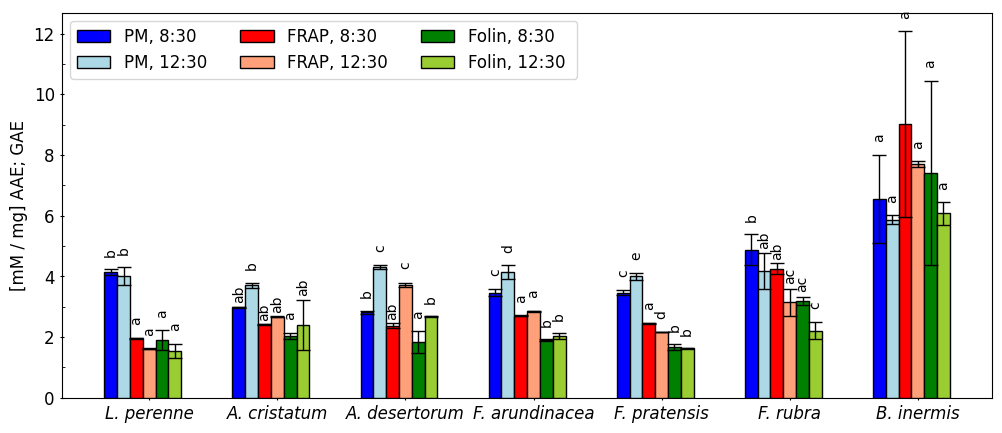

In [59]:
import matplotlib.pyplot as plt
# create data
x = np.arange(len(pd.unique(df['species'].values))) # N of samples

fig, ax = plt.subplots(figsize=(12, 5))
bar_kwargs = {'width':0.1,'linewidth':1,'zorder':5,'edgecolor':'black'}
err_kwargs = {'linewidth':1,'ecolor':'black','capsize':5,'capthick':1,'lolims':False}
# plot data in grouped manner of bar type

import re

colors = ['blue', 'lightblue', 'red', 'lightsalmon', 'green', 'yellowgreen']
i = 0
xx = -0.3
for y in result_values:
  """
  y_w = 0
  if y == 'y1':
    y_w = y1w + y1werr
  if y == 'y2':
    y_w = y2w + y2werr
  y_pos = result_values[y] + result_errors[y + 'err'] + y_w
  draw_letters(10, xx, y_pos, new_ltr[y], True, 0, fsize=10)
  """
  plt.bar(x+xx, result_values[y], color=colors[i],
          yerr=result_errors[y + 'err'], **bar_kwargs,  error_kw=err_kwargs)
  xx += 0.1
  i += 1 # increment the color index


new_result_values = {}
xx = -0.3
for i, species in enumerate(df['species'].unique()):
  new_result_values[species] = []
  for j, (month, method) in enumerate(combinations):
    key = f'y{j+1}'
    new_result_values[species].append(result_values[key][i]+result_errors[key+'err'][i])

for species in df_long['species'].unique().tolist():
  print (letters_by_species[species][0], new_result_values[species])
  draw_letters(10, xx, new_result_values[species], letters_by_species[species][0],
               True, 0, fsize=10)
  xx += 1.



#p1w = plt.bar(x-0.3, y1w, bottom=result_values['y1'], color='violet', yerr=y1werr, **bar_kwargs,  error_kw=err_kwargs)

#p2w = plt.bar(x-0.2, y2w, bottom=result_values['y2'], color='violet', yerr=y2werr, **bar_kwargs,  error_kw=err_kwargs)

# minor ticks
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
ax.yaxis.set_minor_locator(MultipleLocator(2/2))
ax.tick_params(which="major", direction="inout")
ax.tick_params(which="minor", direction="in")


label = pd.unique(df['species'].values)
plt.rc('font', size=12)
plt.xticks(x, label, fontsize=12, fontstyle='italic')
import re
plt.ylabel('[mM / mg] AAE; GAE')
plt.legend((), ncols=3, labels=['PM, 8:30',
                                'PM, 12:30',
                                'FRAP, 8:30',
                                'FRAP, 12:30',
                                'Folin, 8:30',
                                'Folin, 12:30 '])
# [re.sub(r'[\[\]\']', '', str(i)) for i in combinations.tolist()], loc='upper left') # automatic labeling
plt.savefig('anovatest.jpg',dpi=600,bbox_inches='tight')